# **Endothelial subcluster**

Rewriting scanpy template for analysis on Sumner

In [ ]:
import sys
sys.path.append("../code")
from code.data_prep.io import *
from code.data_prep.processing import *
from code.plotting.plot_settings import *
from code.plotting.palette import *

In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import scrublet as scr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sc.settings.verbosity=3

In [3]:
main_dir = "/projects/robson-lab/research/endometriosis/"
sample_id = "Endometriosis-revision-3"
sub_dir = "Endothelial"

sc.settings.figdir = f"{main_dir}figures/{sample_id}"
matplotlib.rcParams["figure.facecolor"]="white"

In [5]:
sc.set_figure_params(dpi=150, color_map='Reds')
sns.set_style("white")

---

In [6]:
full = sc.read_h5ad(f"{main_dir}data/h5ad/{sample_id}/{sub_dir}/{sample_id}-Endo-20220103.h5ad")

In [7]:
full

AnnData object with n_obs × n_vars = 10883 × 21391
    obs: 'sequencing_saturation', 'Patient_id', 'stage', 'scrublet_predicted_doublet', 'scrublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'library', '10x_chemistry', 'sample_name', 'sampleid', 'sample_type', 'leiden', 'leiden_R1', 'leiden_R2', 'leiden_R3', 'leiden_R4', 'leiden_R5', 'leiden_R6', 'leiden_R7', 'visible_doublet', 'cluster', 'cluster_R1', 'celltype', 'celltype_main'
    var: 'gene_ids', 'mitochondrial', 'hemoglobin', 'total_counts', 'n_cells_by_counts', 'ribosomal', 'cell_cycle', 'stress_response', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
    u

#### Batch Corrections & UMAP Computing

In [8]:
%load_ext rpy2.ipython

In [9]:
sc.pp.pca(full, svd_solver="arpack",use_highly_variable=True)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


In [10]:
pcs = full.obsm["X_pca"]
metadata = full.obs
covariates = ["Patient_id","stage"]
thetas = np.array([2,1])

In [11]:
%%R -i pcs -i covariates -i thetas -i metadata -o pcs_harmony
library(harmony)
pcs_harmony <- HarmonyMatrix(
    pcs,
    metadata,
    vars_use=covariates,
    theta=thetas,
    do_pca=FALSE
)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [13]:
harmonized = load_pcs(full, pcs_harmony)

In [14]:
sc.pl.pca_variance_ratio(harmonized,show=False)

In [ ]:
sc.pp.neighbors(harmonized, n_neighbors=15, n_pcs=15, metric="correlation")
sc.tl.umap(harmonized, min_dist=0.05)

---

#### Clustering

In [8]:
harmonized = sc.read(f"{main_dir}data/h5ad/{sample_id}/{sub_dir}/{sample_id}-harmonized-Endo-20220104.h5ad")

running Leiden clustering


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 6 clusters and added
    'endo_leiden', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 7 clusters and added
    'endo_leiden_R1', the cluster labels (adata.obs, categorical) (0:00:00)


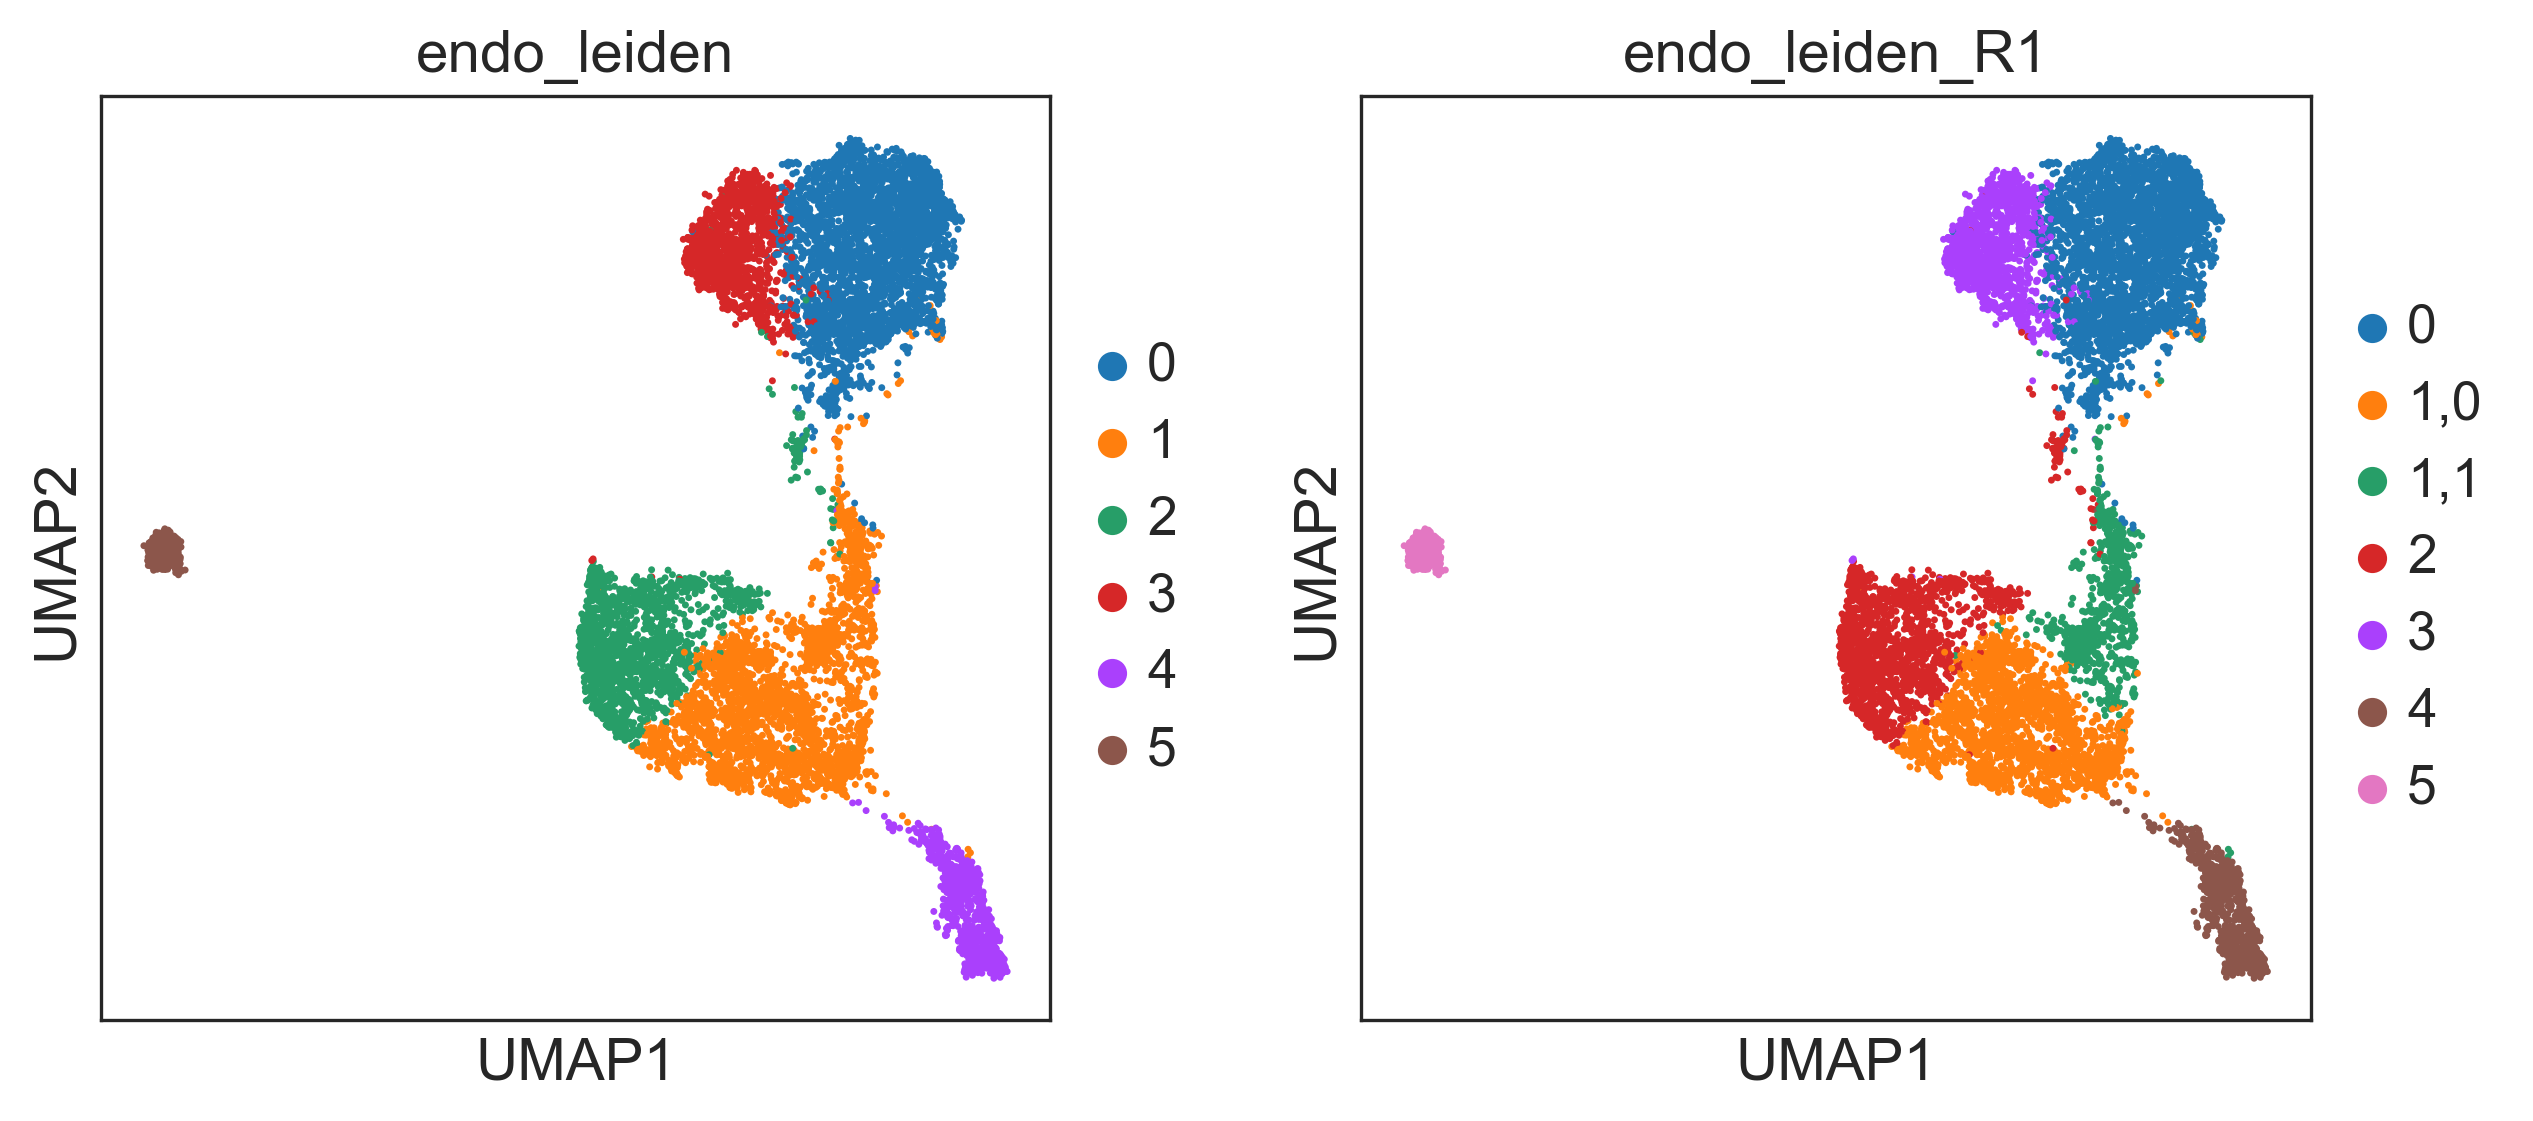

In [21]:
sc.tl.leiden(harmonized, resolution=0.3,key_added="endo_leiden")
sc.tl.leiden(harmonized, resolution=0.2, key_added="endo_leiden_R1", restrict_to=("endo_leiden", ['1']))
sc.pl.umap(harmonized, 
           color=["endo_leiden","endo_leiden_R1"],
           use_raw=False,
          )

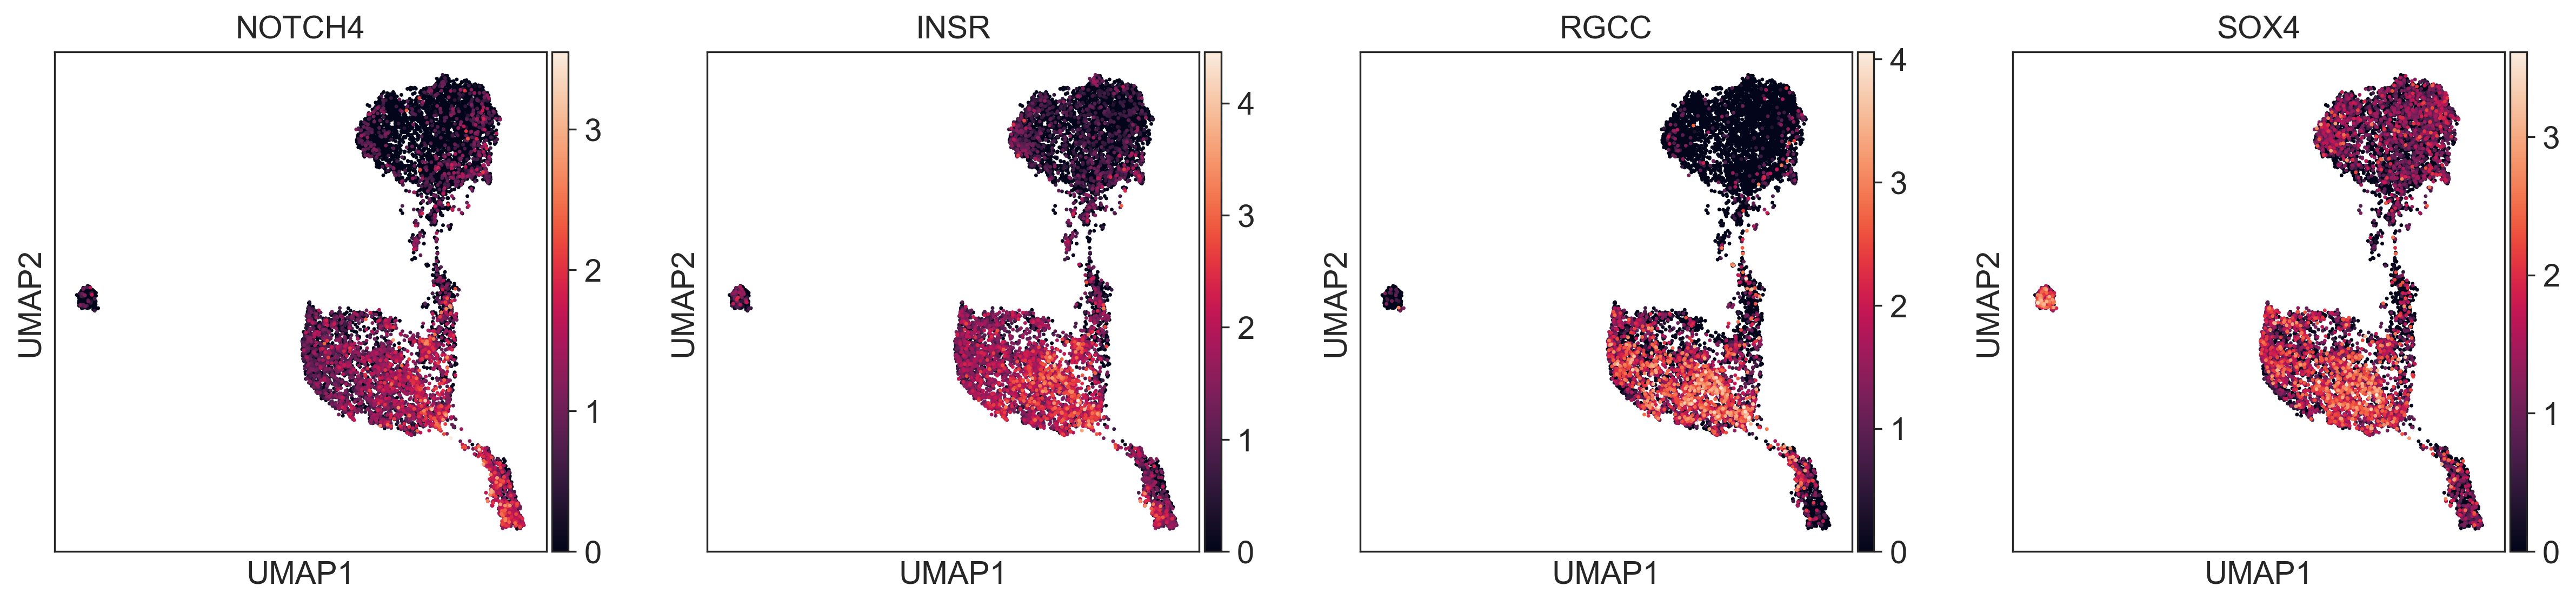

In [22]:
sc.pl.umap(harmonized, color=["NOTCH4","INSR","RGCC","SOX4"])

In [23]:
save_adata(harmonized, "harmonized-Endo", subdir=sub_dir)

---

#### Doublet Identification

***Visible doublet***

In [25]:
detect_umap_doublets(harmonized, cluster_key= "endo_leiden_R1", t=8)
sc.pl.umap(harmonized,color=["visible_doublet"], color_map="Reds")

In [26]:
clean = harmonized[~harmonized.obs.visible_doublet,:].copy()

In [28]:
reorder_clusters_hierarchical(clean,cluster_key="endo_leiden_R1",new_key='endo_cluster')

AnnData object with n_obs × n_vars = 10751 × 21391
    obs: 'sequencing_saturation', 'Patient_id', 'stage', 'scrublet_predicted_doublet', 'scrublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'library', '10x_chemistry', 'sample_name', 'sampleid', 'sample_type', 'leiden', 'leiden_R1', 'leiden_R2', 'leiden_R3', 'leiden_R4', 'leiden_R5', 'leiden_R6', 'leiden_R7', 'cluster', 'cluster_R1', 'celltype', 'celltype_main', 'endo_leiden', 'endo_leiden_R1', 'visible_doublet', 'endo_cluster'
    var: 'gene_ids', 'mitochondrial', 'hemoglobin', 'total_counts', 'n_cells_by_counts', 'ribosomal', 'cell_cycle', 'stress_response', 'highly_variable', 'means', '

In [29]:
sc.pl.umap(clean, color=["endo_cluster"])

In [30]:
save_adata(clean,"scrubs-clean-endo",subdir=sub_dir)

---
### Final Subtypes Clustering
date: Jan 27th, 2021
<br> Final clustering based on previous analysis (cell type markers, differential gene expression, literature reviews)

In [7]:
clean =  sc.read(f"{main_dir}data/h5ad/{sample_id}/{sub_dir}/{sample_id}-scrubs-clean-endo-20220104.h5ad")

In [45]:
clean.obs["subtypes"] = clean.obs.endo_cluster.map({
    "1":"LEC",
    "2":"EC-artery",
    "3":"EC-capillary",
    "4":"EC-tip",
    "5":"EC-HEV",
    "6":"EC-PCV",
    "7":"EC-aPCV"
}).astype("category")

clean.obs["subtypes"].cat.reorder_categories([
    "LEC","EC-artery","EC-tip","EC-capillary", "EC-HEV","EC-PCV","EC-aPCV"
],
    inplace=True)

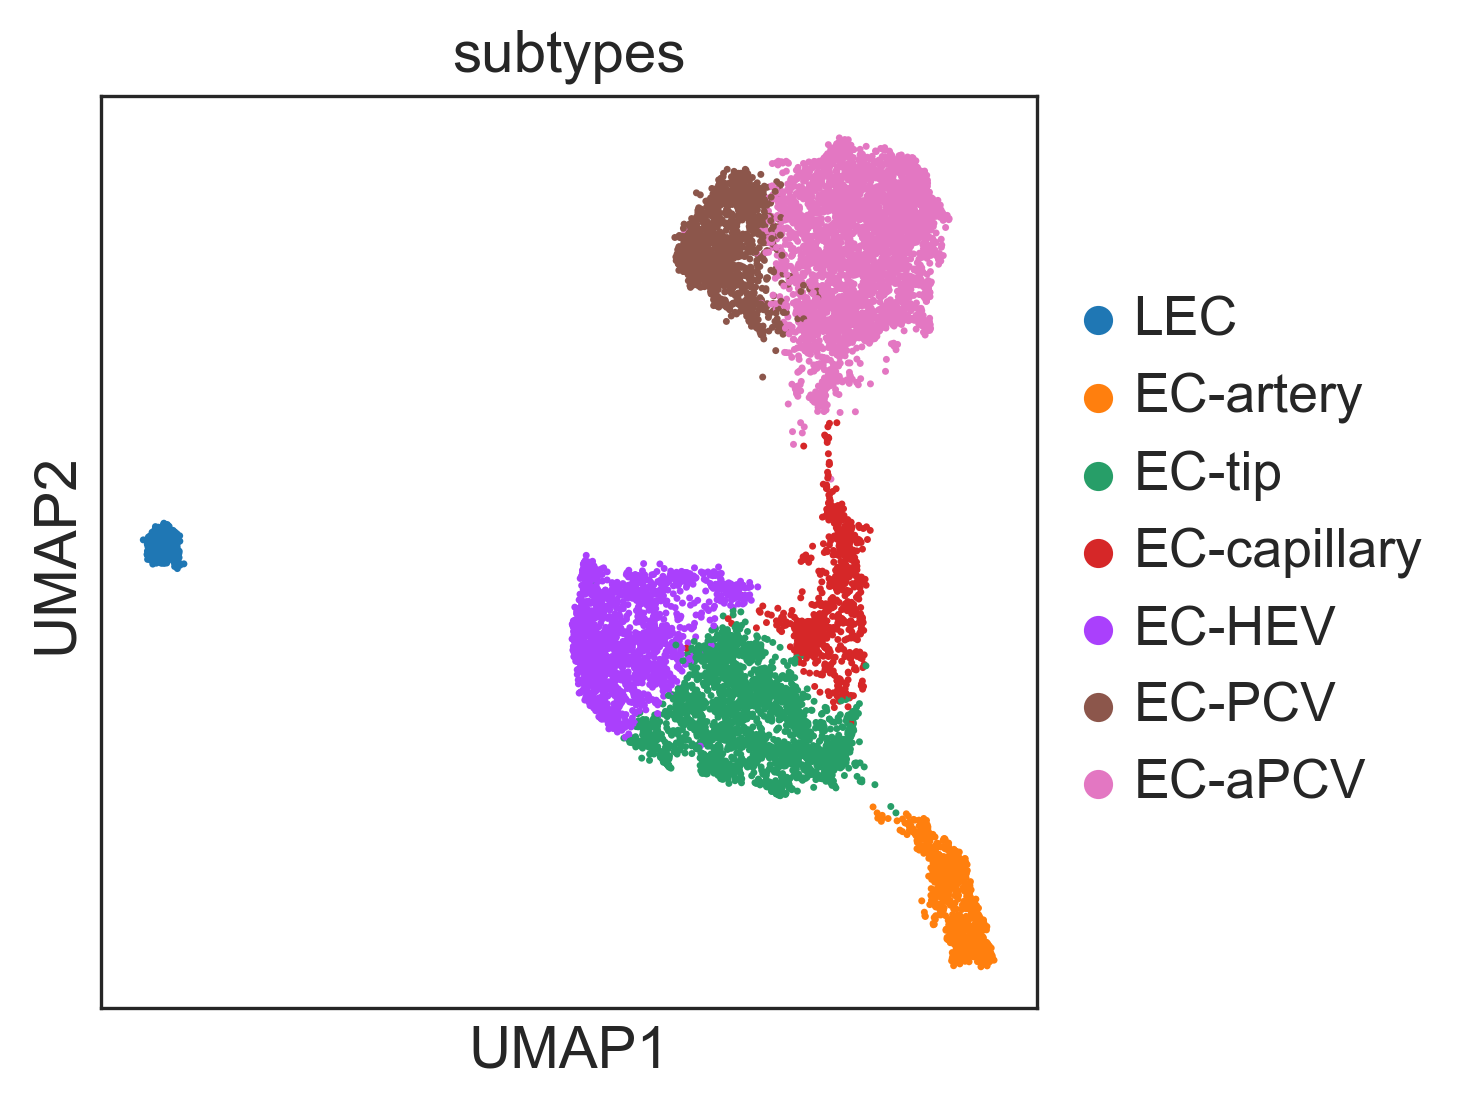

In [46]:
sc.pl.umap(clean, color = ["subtypes"])

In [50]:
save_adata(clean,"final-endo",subdir=sub_dir)

---

***Cell_type Markers***

Note:
`sc.tl.rank_genes_groups(adata, groupby="cluster",use_raw=False,)` and `sc.tl.filter_rank_genes_groups(clean, use_raw=False)` will cause warning for adata saving, and subsequently error in adata loading. Copy the adata and run this function for doublet identification purpose. Once `doublet` identified, filter and save the original `adata`.

In [51]:
clean_copy = clean.copy()
#clean_copy.raw = sc.AnnData(clean_copy.layers["raw"], var=clean_copy.var, obs=clean_copy.obs)
clean_copy.raw = clean_copy
sc.tl.rank_genes_groups(clean_copy, groupby="subtypes",use_raw=False, method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:16)


Filtering genes using: min_in_group_fraction: 0.6 min_fold_change: 0.7, max_out_group_fraction: 0.5
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_subtypes']`


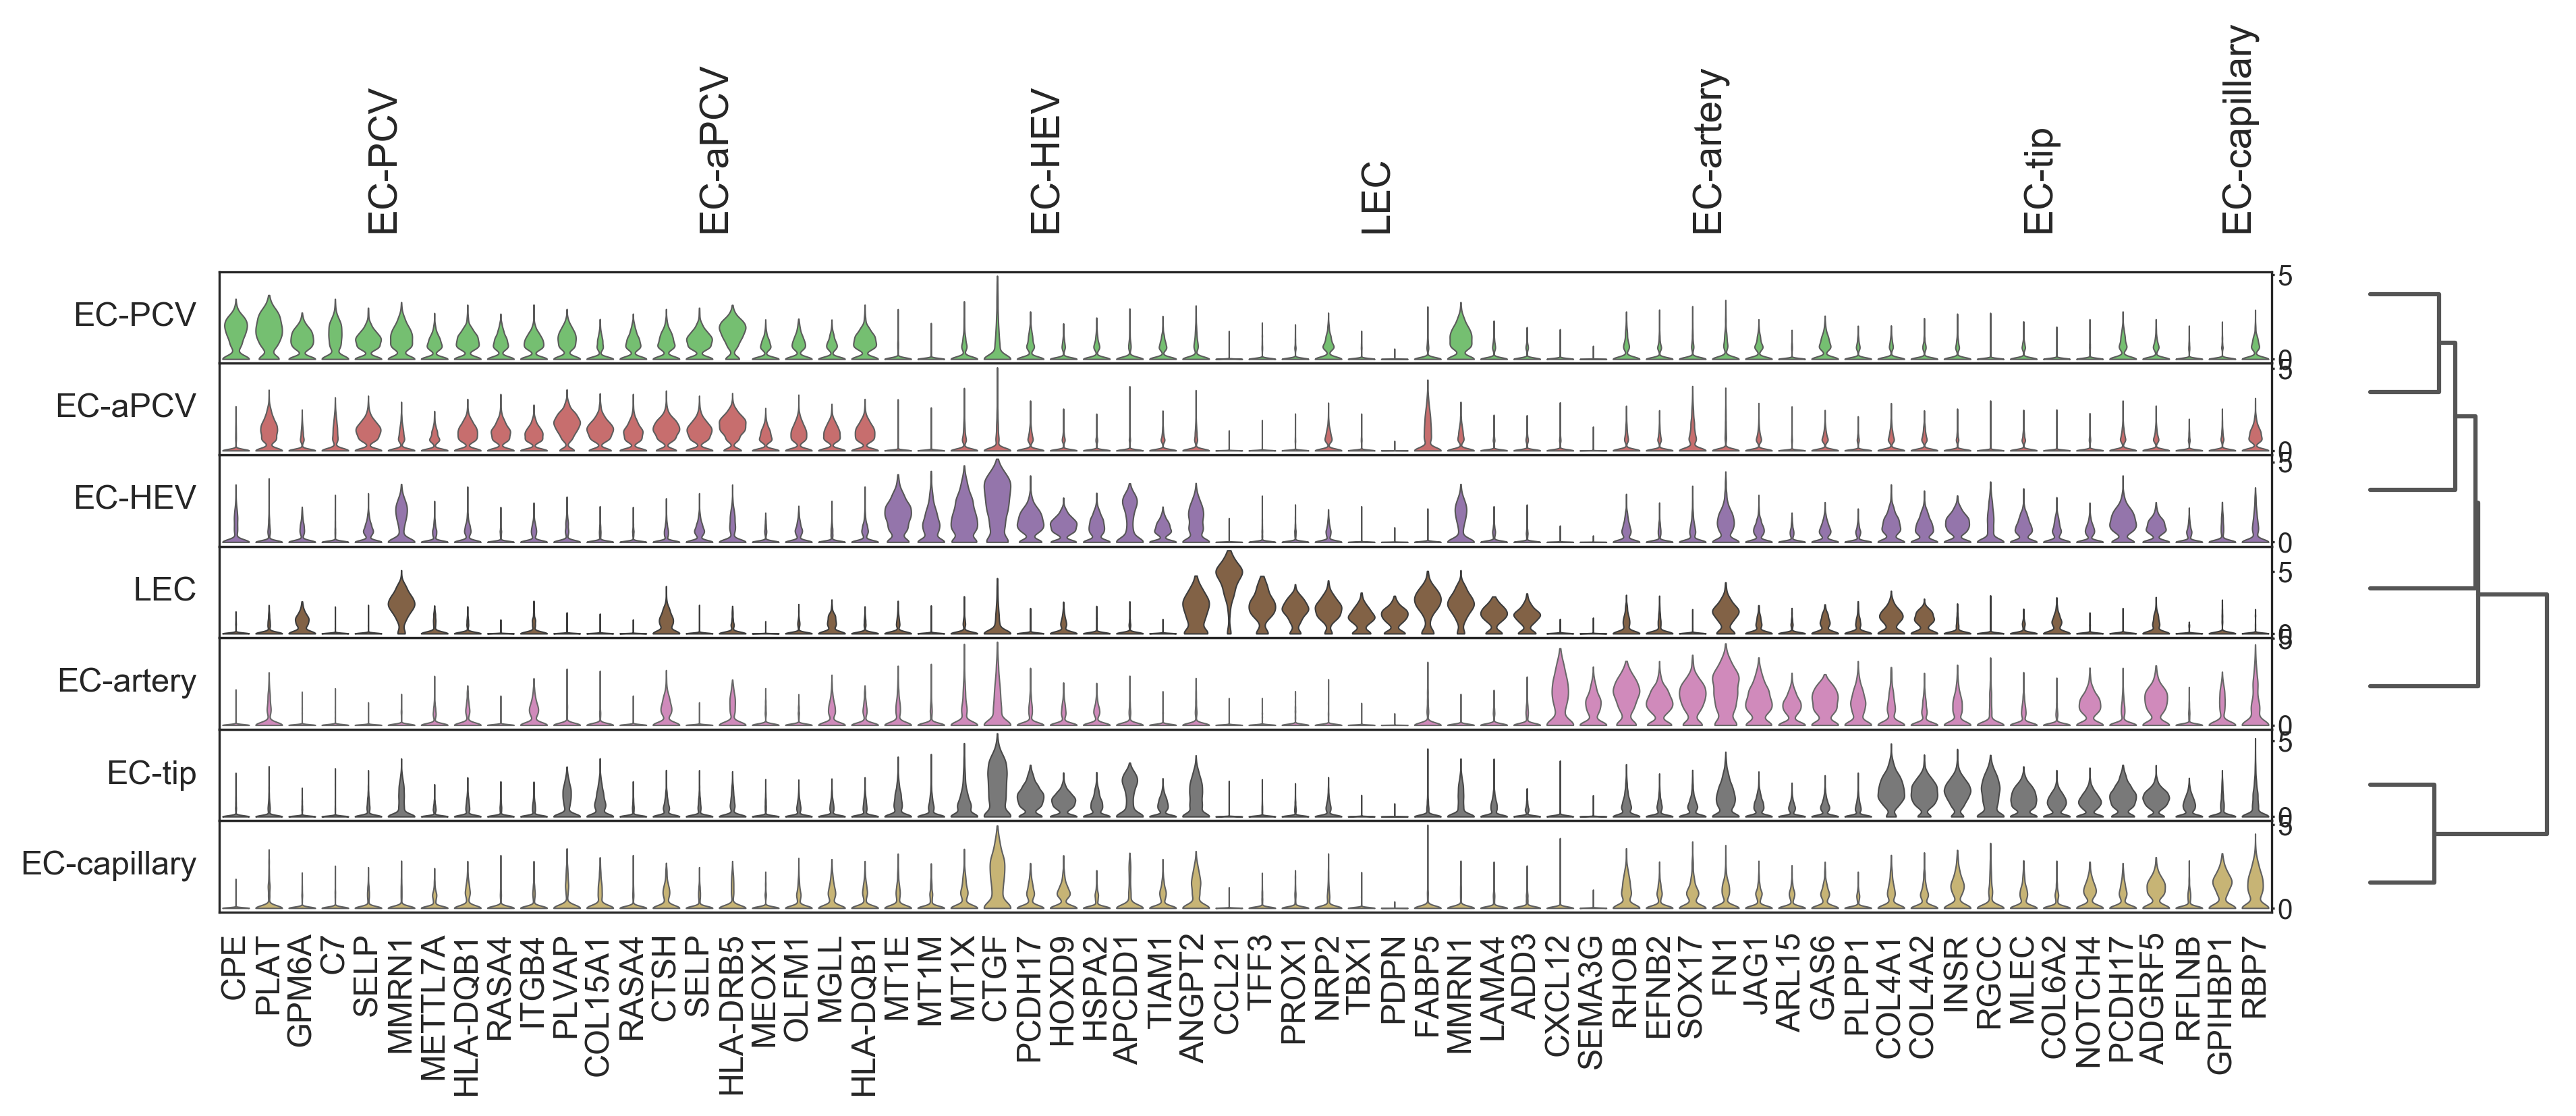

In [52]:
sc.tl.filter_rank_genes_groups(clean_copy,use_raw=False,
                               min_fold_change=0.7,min_in_group_fraction=0.6, max_out_group_fraction=0.5)
sc.pl.rank_genes_groups_stacked_violin(clean_copy,key='rank_genes_groups_filtered', n_genes=10)

   **1. Differential expression in EC_tip & EC_capillary between sample_type**

In [53]:
capil = clean_copy[clean_copy.obs.subtypes.isin(["EC-tip","EC-capillary"])]
sc.tl.rank_genes_groups(capil, groupby="sample_type",use_raw=False,method='wilcoxon',
                       key_added="rank_genes_groups", reference="Eutopic Normal")

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


Filtering genes using: min_in_group_fraction: 0.7 min_fold_change: 1, max_out_group_fraction: 0.5
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_sample_type']`
categories: Ectopic, Ectopic Adj, Ectopic Ovary, etc.
var_group_labels: Ectopic, Ectopic Adj, Ectopic Ovary, etc.


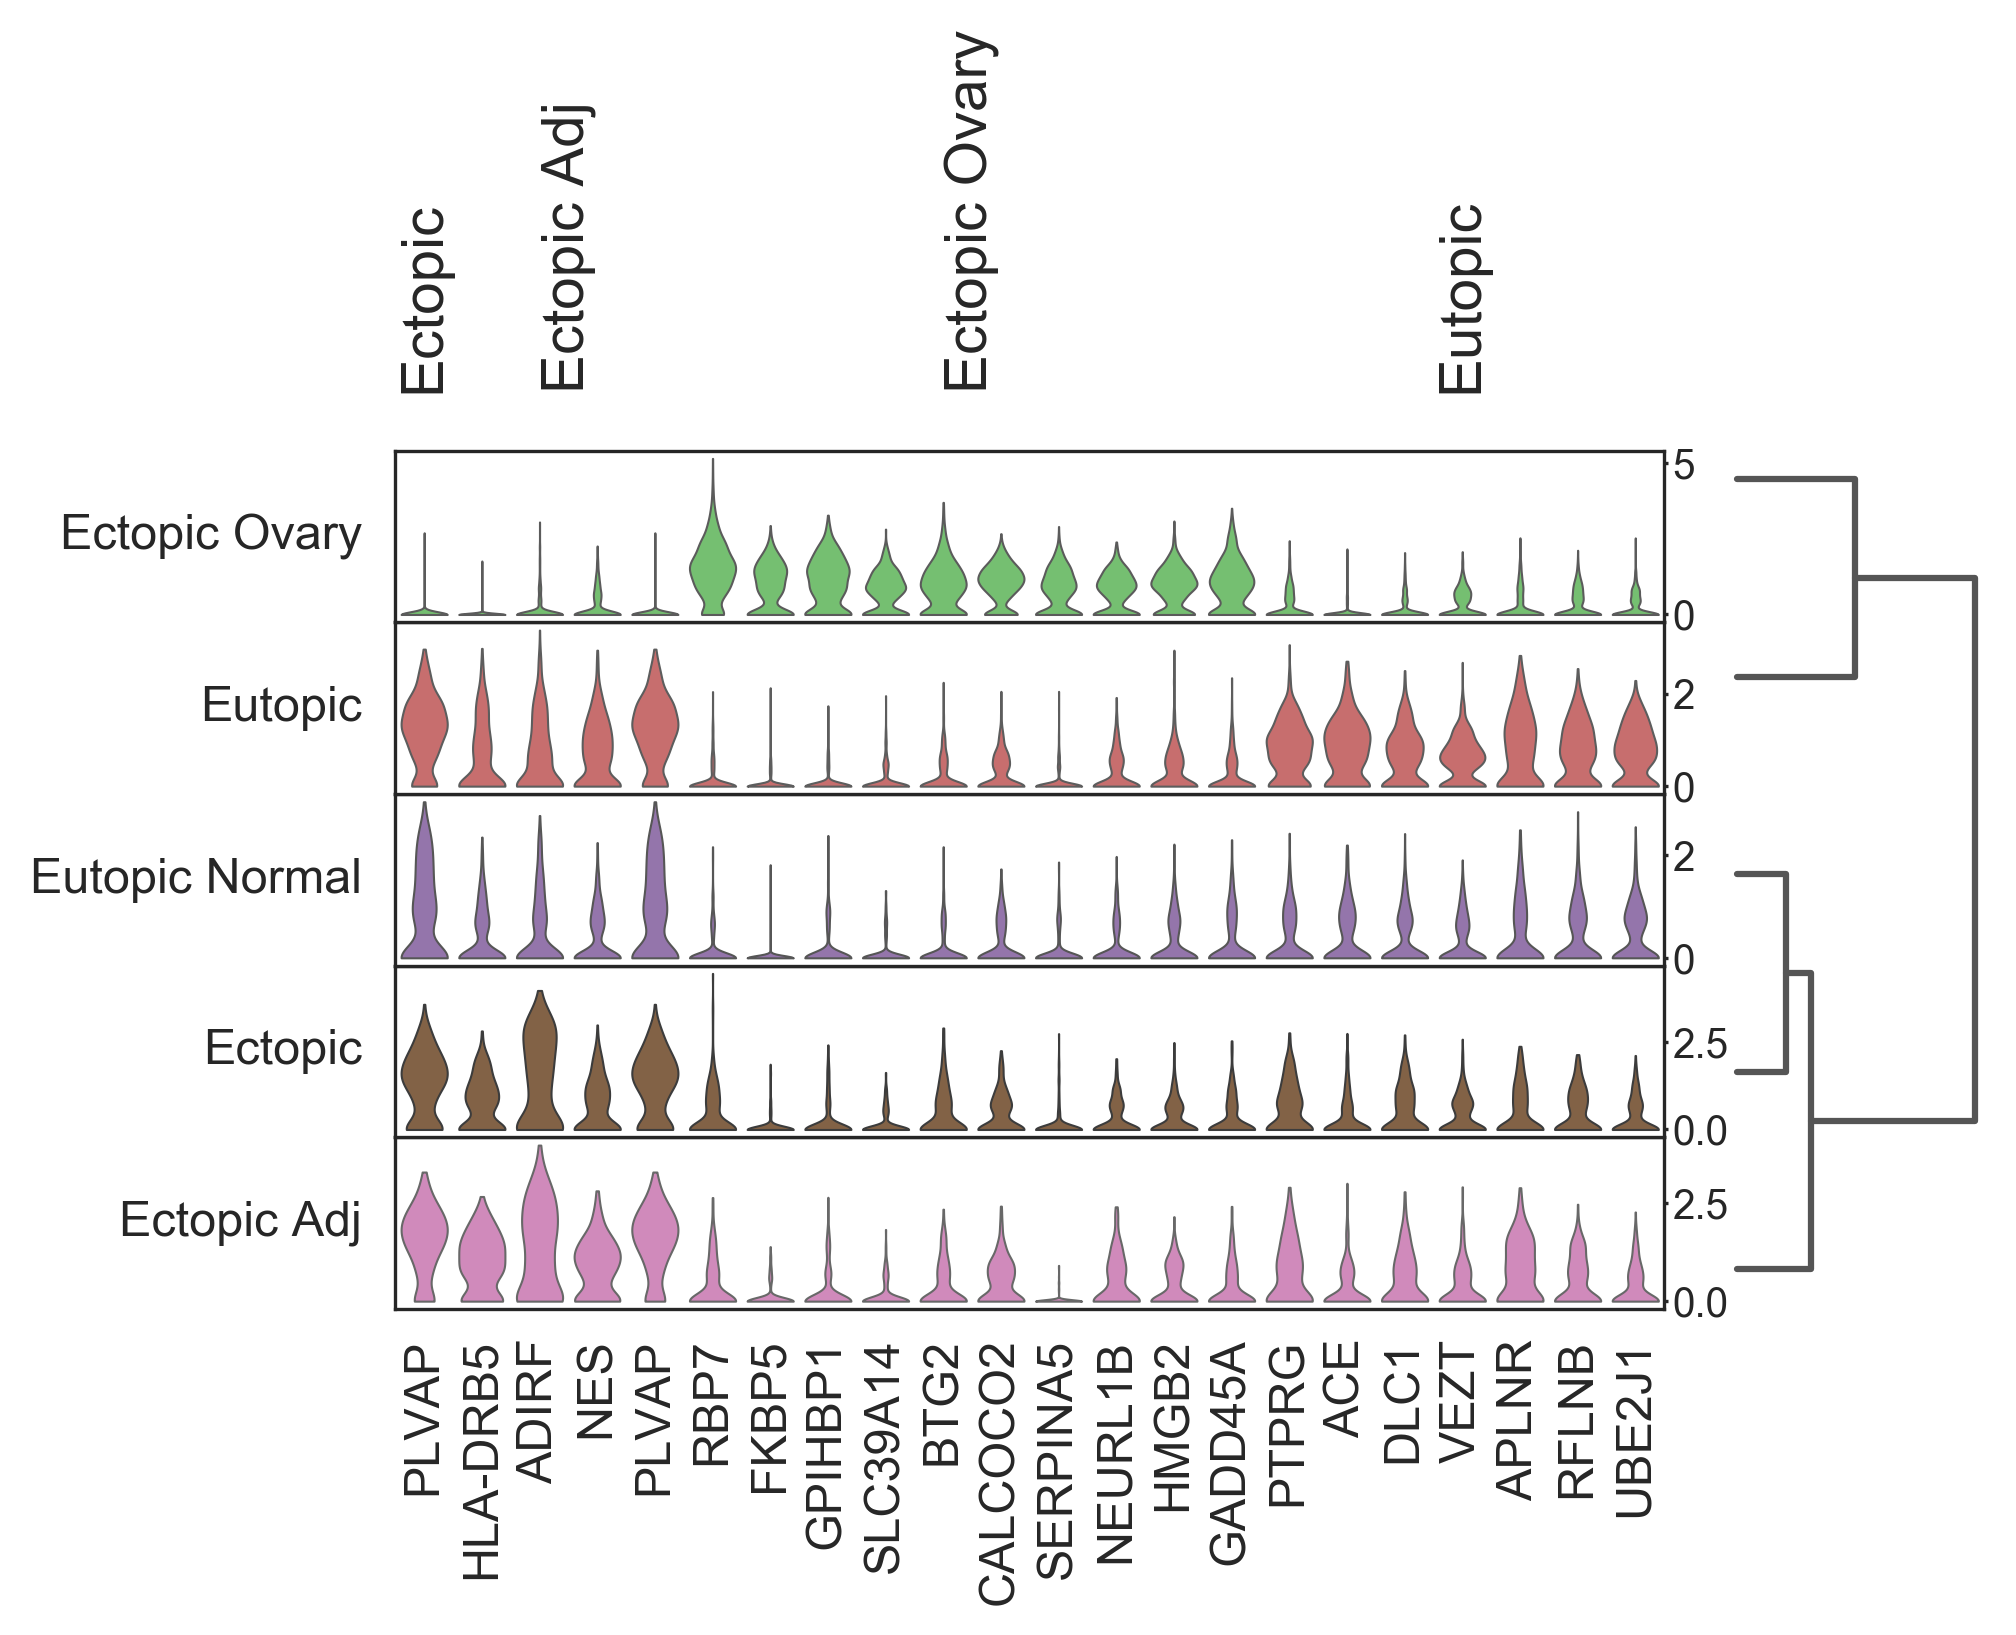

In [54]:
sc.tl.filter_rank_genes_groups(capil,use_raw=False,
                               min_fold_change=1,min_in_group_fraction=0.7, max_out_group_fraction=0.5,
                               key = "rank_genes_groups",
                               key_added="rank_genes_groups_filtered")
sc.pl.rank_genes_groups_stacked_violin(capil, key='rank_genes_groups_filtered', n_genes=10)

In [55]:
goi = ["TIMP3","AQP1","EGR1","IL1R1","CCL14","RBP7","MIB1","DLL4","NOTCH1","NOTCH4","NEURL1B"]

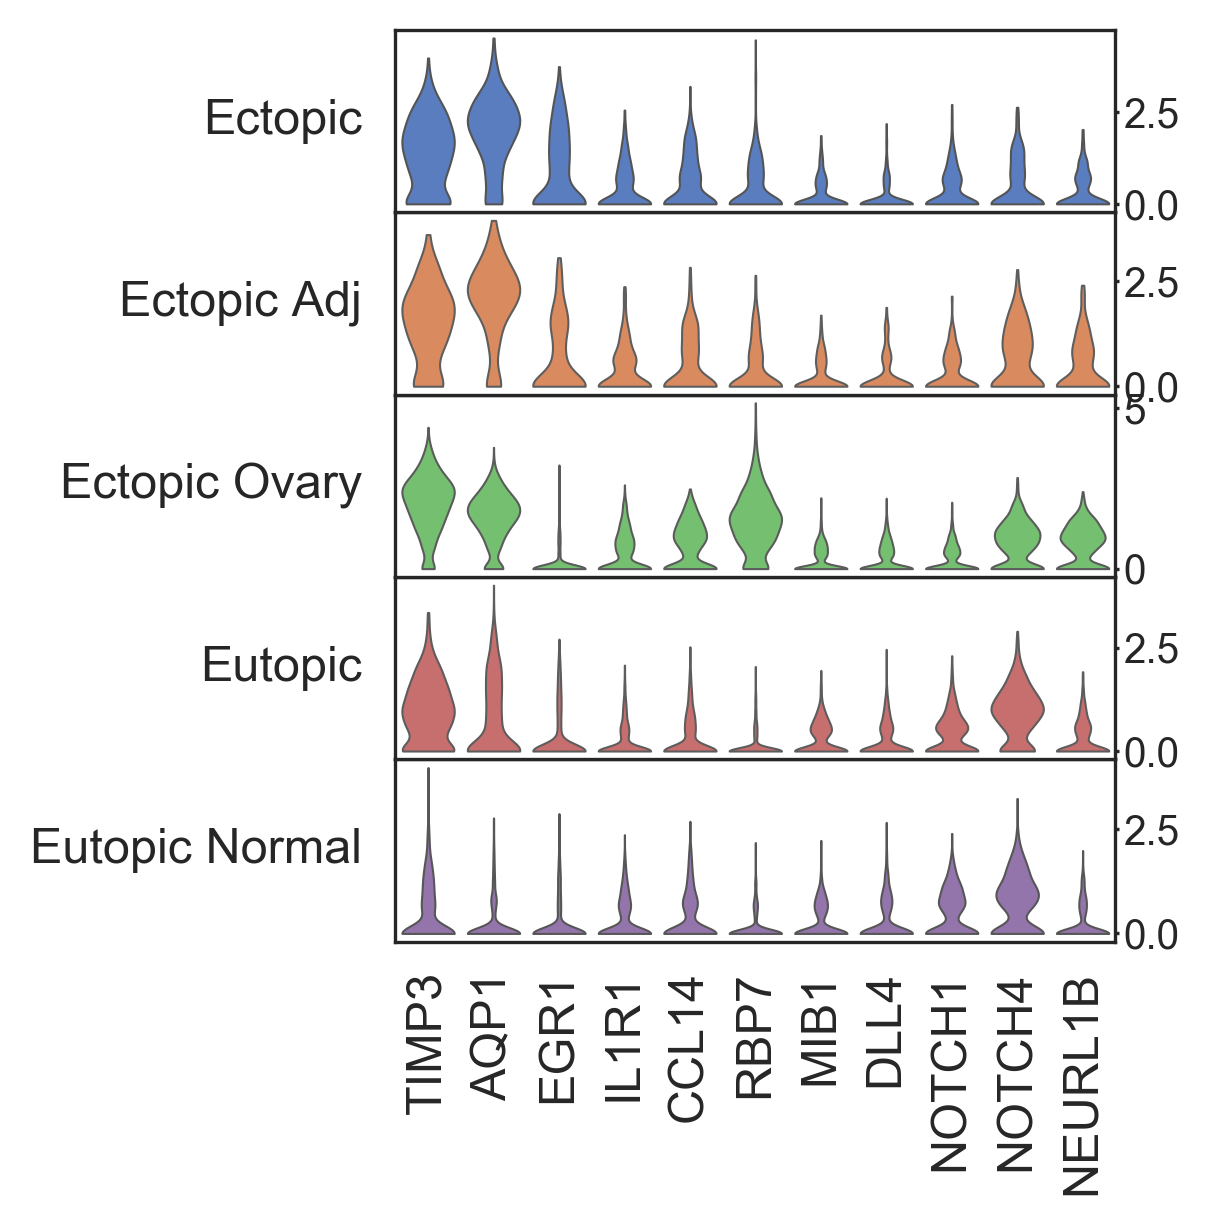

In [57]:
sc.pl.stacked_violin(capil,var_names=goi,groupby="sample_type")

**2. Differential expression in LEC group between sample_type**

In [58]:
LEC = clean_copy[clean_copy.obs.subtypes == "LEC"]
sc.tl.rank_genes_groups(LEC, groupby="sample_type",use_raw=False,method='wilcoxon',
                       key_added="rank_genes_groups", reference="Eutopic Normal")

ranking genes


Trying to set attribute `.uns` of view, copying.


--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


Filtering genes using: min_in_group_fraction: 0.7 min_fold_change: 1, max_out_group_fraction: 0.5
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_sample_type']`
categories: Ectopic, Ectopic Adj, Ectopic Ovary, etc.
var_group_labels: Ectopic, Ectopic Adj, Ectopic Ovary, etc.


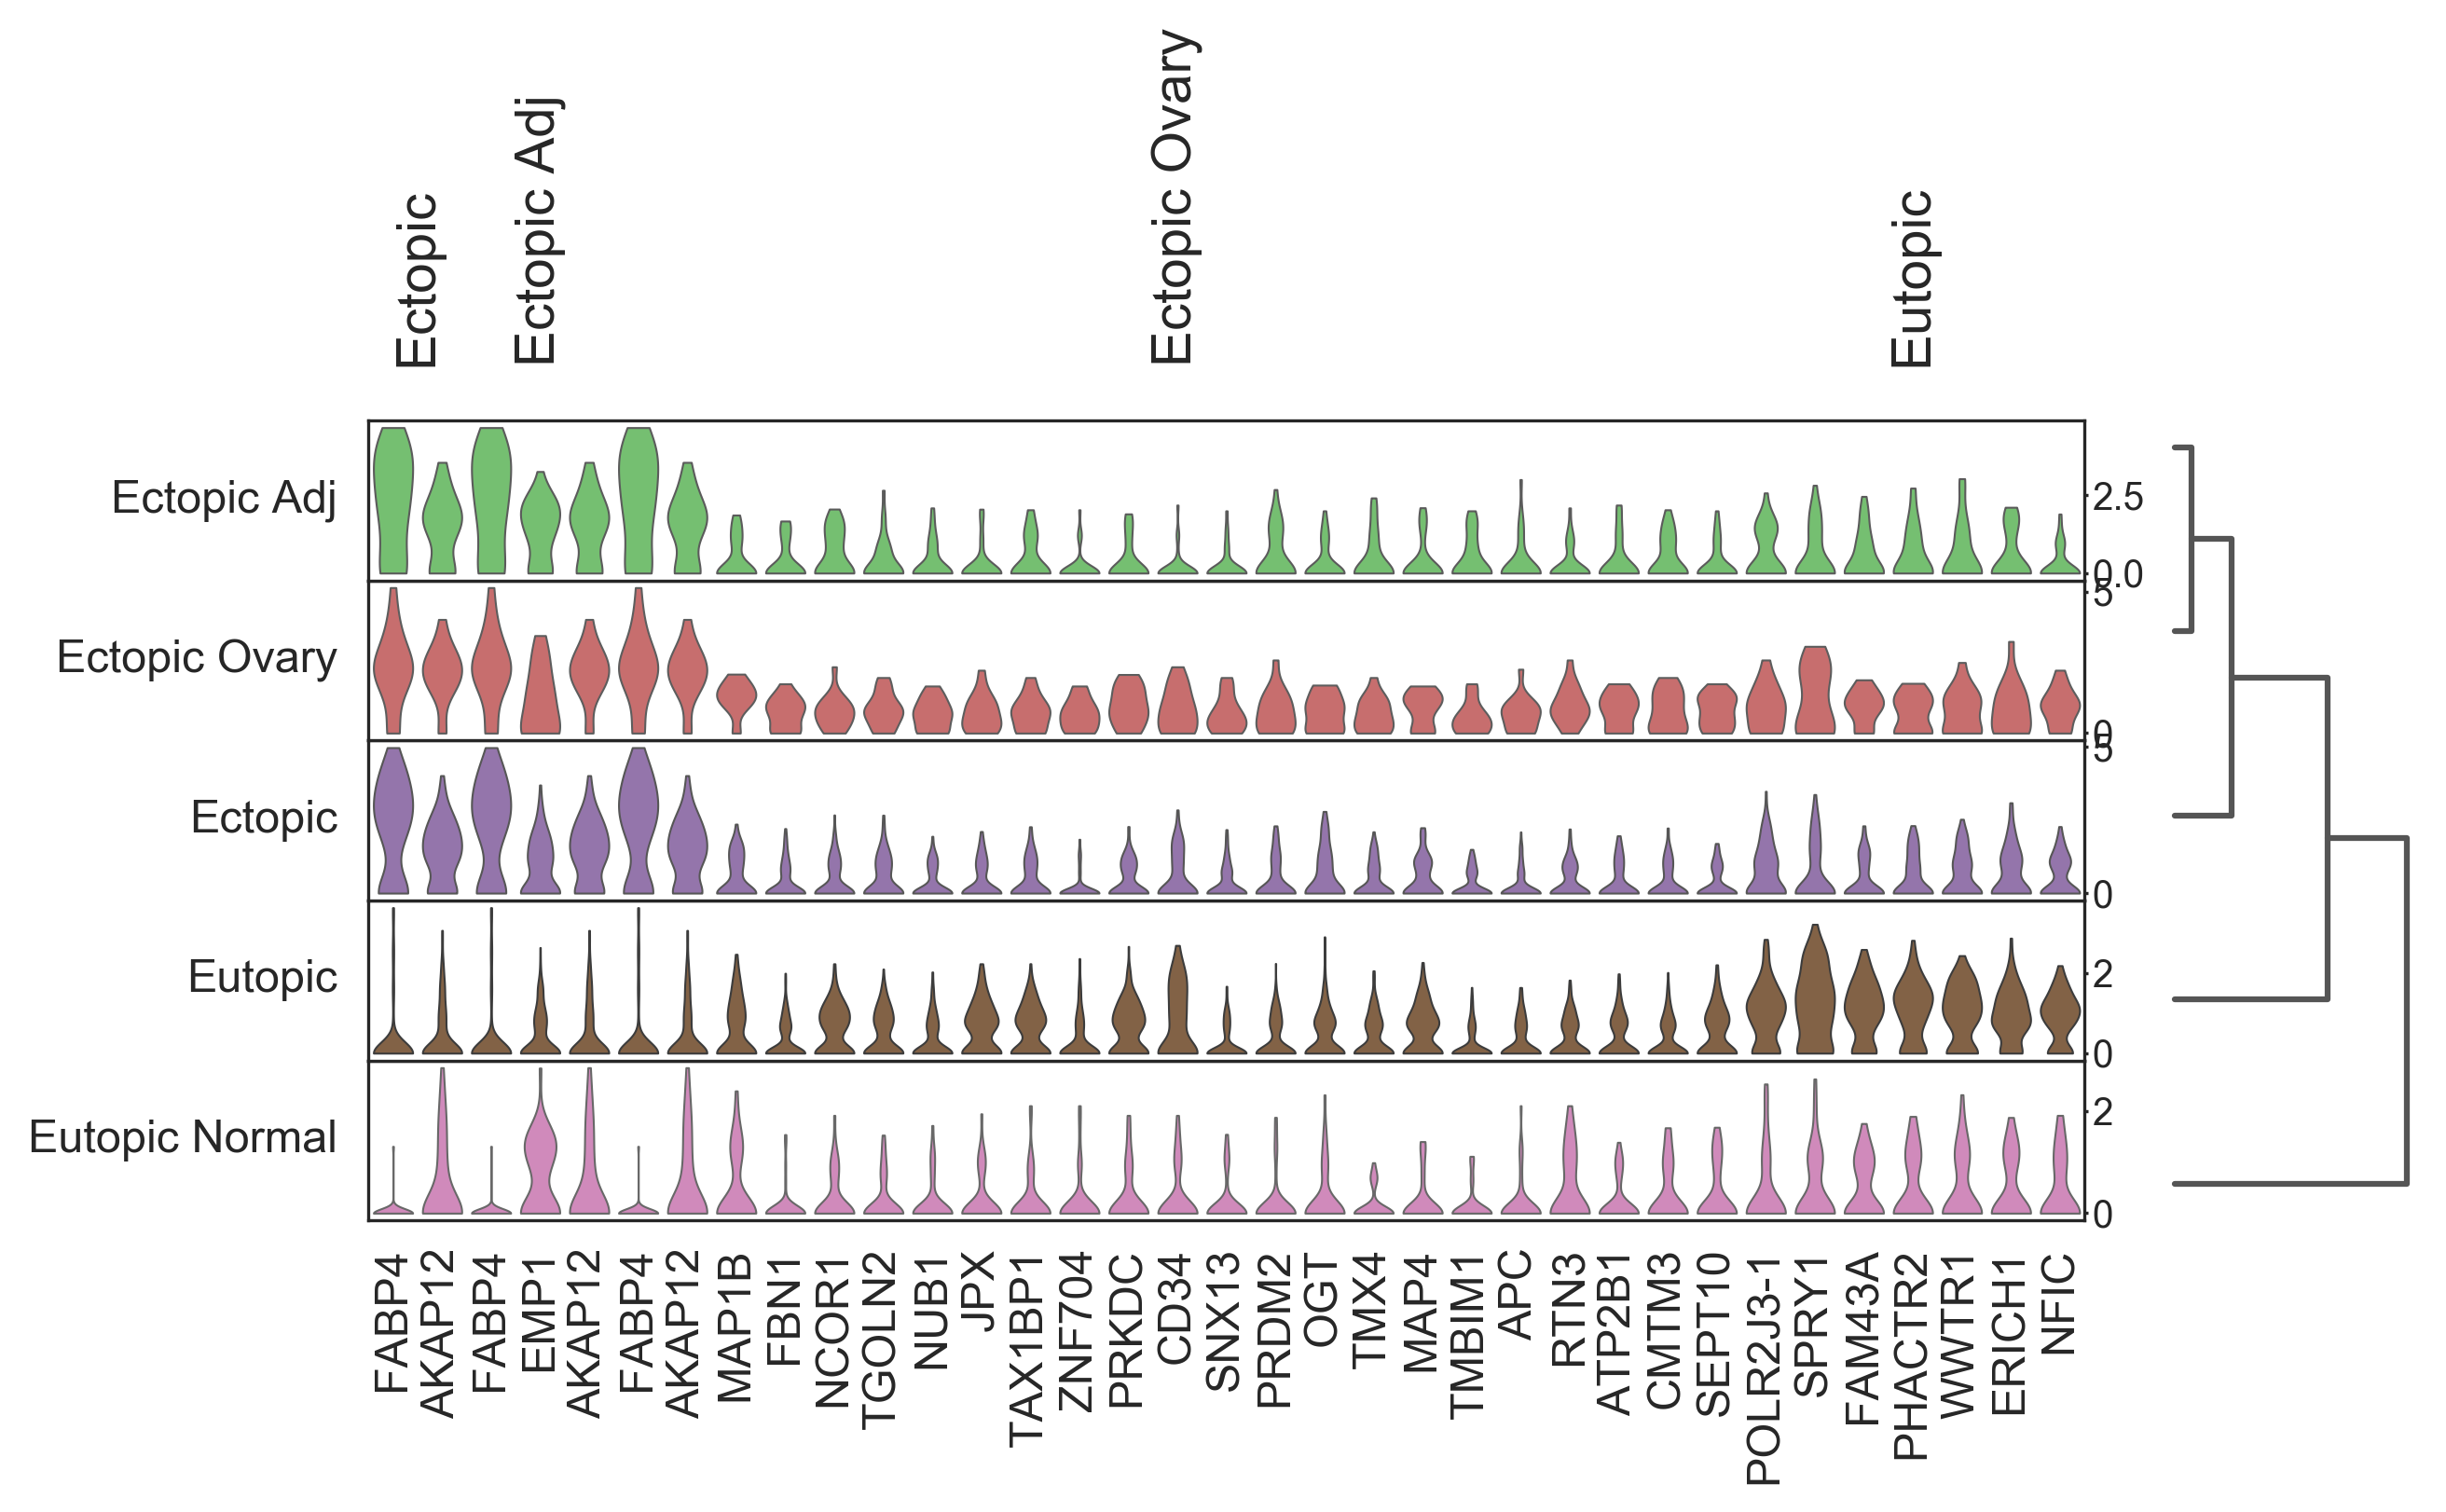

In [59]:
sc.tl.filter_rank_genes_groups(LEC,use_raw=False,
                               min_fold_change=1,min_in_group_fraction=0.7, max_out_group_fraction=0.5,
                               key = "rank_genes_groups",
                               key_added="rank_genes_groups_filtered")
sc.pl.rank_genes_groups_stacked_violin(LEC, key='rank_genes_groups_filtered', n_genes=30)

---